## 0. Import and Setups

In [3]:
!pip install matplotlib seaborn missingno -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [6]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
DATA_PATH = './train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 5.47 s, sys: 544 ms, total: 6.02 s
Wall time: 6.03 s


## 1.1 기본적인 내용 파악

정리하면,   
`userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
`assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
`testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
`answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
`Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
`KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   
특성 별로 자세히 살펴봅시다.

### 특성의 기본 정보

In [7]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [12]:
len(df.userID.unique()), len(df.assessmentItemID.unique()), len(df.testId.unique())

(6698, 9454, 1537)

In [13]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


유저의 수는 대략 6700명이고 시험지는 대략 1500개 그리고 문항 수는 9500개이다. KnowledgeTag는 대략 900개, 

- KnowledgeTag가 시험지별로 골구로 분포되어 있는지 상이하게 분포되어 있는지?
- 시험지에서 주어지는 문항은 순서대로 보지 않나?

### 일련 번호 분석

#### 첫 번째 단어 A
A 밖에 없는 것을 확인할 수 있음

In [5]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

#### 문항 일련 번호 내 시험지 번호

In [14]:
len(df)

2266586

In [6]:
# 
sum(df['assessmentItemID'].apply(lambda x: x[1:7]) == df['testId'].apply(lambda x: x[1:4]+x[7:]))

2266586

In [17]:
df['assessmentItemID'][0], df['testId'][0]

('A060001001', 'A060000001')

#### 시험지 번호 가운데 3자리 모두 000

In [7]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

- assessmentItemID는 A로 시작한다.
- assessmentItemID[1:7] == (testId[1:4] + test[7:])
- 왜 하필 가운데 3자리가 0일까

## 1.2 기술 통계량 분석

In [19]:
def percentile(s):
    return np.sum(s) / len(s)

### 사용자 분석

In [22]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


- assessmentItemID <br>
: mean이 의미하는 것은 한 사람당 푼 문제의 수가 338이라는 것
- answerCode <br> 
: 이 의미하는 것은 전체 평균으로는 65.44% 였는데 유저 평균으로 바꾸니 62.8%로 줄었다.

In [20]:
df.sample(3)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
1026148,1536,A050010001,A050000010,0,2020-02-18 02:59:54,2619
1140667,1761,A020142001,A020000142,1,2020-10-13 06:28:23,8123
1877938,3650,A060085002,A060000085,0,2020-05-29 11:35:05,10403


#### 사용자 문항 개수 도수분포표

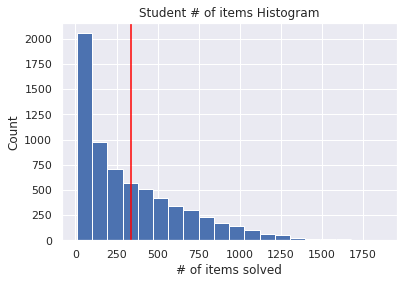

In [23]:
fig, ax = plt.subplots()
stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)
ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

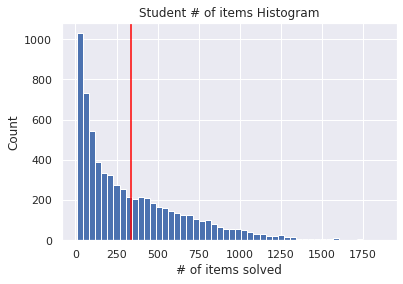

In [26]:
fig, ax = plt.subplots()
stu_groupby['assessmentItemID'].hist(bins=50, ax=ax)
ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

#### 사용자 정답률 도수분포표

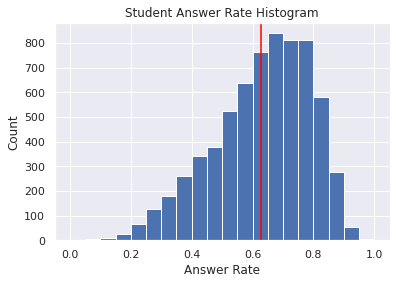

In [27]:
fig, ax = plt.subplots()
stu_groupby['answerCode'].hist(bins=20)
ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 문항 별 정답률 분석

In [28]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


아까는 'userID'로 묶었는데 지금은 'assessmentItemID'로 묶었다.

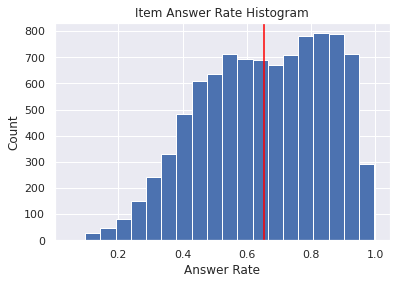

In [29]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 시험지 별 정답률 분석

In [30]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


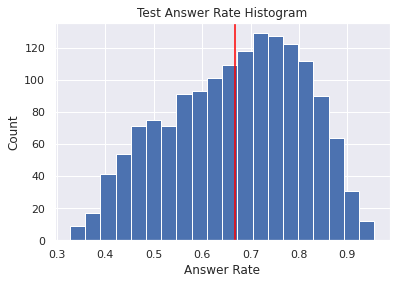

In [31]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

되게 쉽게 EDA를 하는데 이쁘다...

시험지 별 정답률 'testID', 하나의 시험지에 대충 문항 수가 몇 개 있는지?

### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?

Text(0.5, 1.0, '# of Questions - Answer Rate')

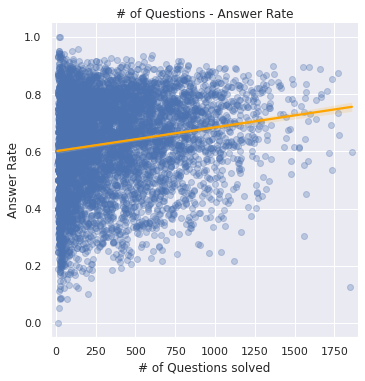

In [32]:
g = sns.lmplot(data=stu_groupby, x='assessmentItemID', y='answerCode',
              scatter_kws={'alpha':0.3}, line_kws={"color": "orange"})
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))
ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [18]:
print(f"Correlation between # of Tags being solved - Answer Rate: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

Correlation between # of Tags being solved - Answer Rate: 0.168


In [36]:
stu_groupby

,assessmentItemID,answerCode
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
5,833,0.795918
6,921,0.442997
...,...,...
7436,15,0.466667
7437,16,0.375000
7438,16,0.750000


In [37]:
stu_groupby.corr() # 상관 관계였구나

,assessmentItemID,answerCode
assessmentItemID,1.000000,0.168041
answerCode,0.168041,1.000000


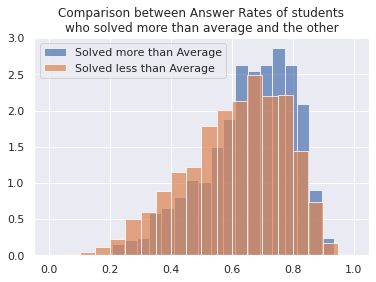

In [39]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average')
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average')
ax.legend()

많이 풀수록, 정답률이 올라가는 것을 보여준다.

### 더 많이 노출된 태그가 정답률이 더 높은가?

In [40]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


In [43]:
tag_groupby.head(5)  # userID: count, 

,userID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178


Text(0.5, 1.0, '# of Tags Exposed - Answer Rate')

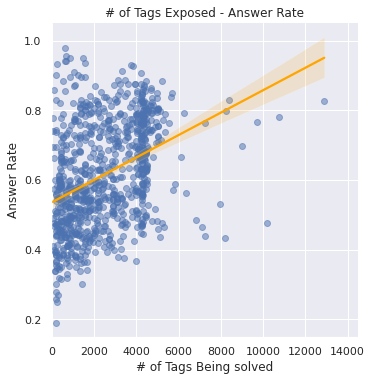

In [44]:
g = sns.lmplot(data=tag_groupby, x='userID', y='answerCode',
              scatter_kws={'alpha':0.5}, line_kws={"color": "orange"})
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))
ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate')

In [45]:
print(f"Correlation between # of Tags being solved - Answer Rate: {tag_groupby.corr()['answerCode']['userID']:.3f}")

Correlation between # of Tags being solved - Answer Rate: 0.376


전혀 **관계없는 것** 같다.

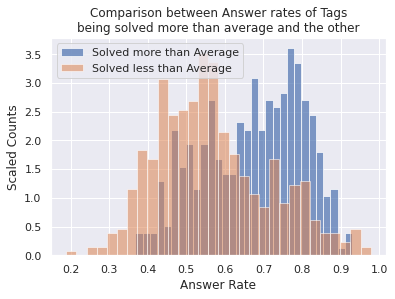

In [65]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')
tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=30, density=1, stacked=True, label='Solved more than Average')
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=30, density=1, stacked=True, label='Solved less than Average')
ax.legend()

또 이렇게 보니깐.... 중요한 Feature인 것 같기도 하고

### 문항을 풀수록 실력이 늘어나는가?

In [51]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

In [48]:
_cumsum

,answerCode
0,1
1,2
2,3
3,4
4,5
...,...
2266581,1
2266582,2
2266583,3
2266584,4


In [49]:
_cumcount

,answerCode
0,1
1,2
2,3
3,4
4,5
...,...
2266581,5
2266582,6
2266583,7
2266584,8


In [54]:
cum_ans.sample(10)

,answerCode,userID
2216308,0.812500,6019
589782,0.804511,832
627943,0.730769,896
1882196,0.674699,3661
2207702,0.157895,5875
1110865,0.597122,1698
313940,0.894737,422
388648,0.717949,532
1759188,0.720339,3225
2134357,0.666667,5060


누적 합, 맞춘 것만 카운트 됨 <br>
누적 갯수, 푼 문제들 전체 카운트 됨

푼 문항의 갯수가 중앙값 부근인 10명의 학생들 (230)

In [55]:
df.userID.nunique()

6698

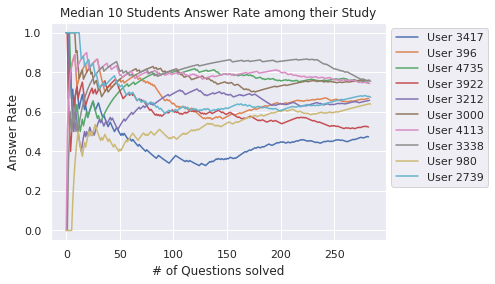

In [56]:
fig, ax = plt.subplots()

ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]

for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')

ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들 (65%)

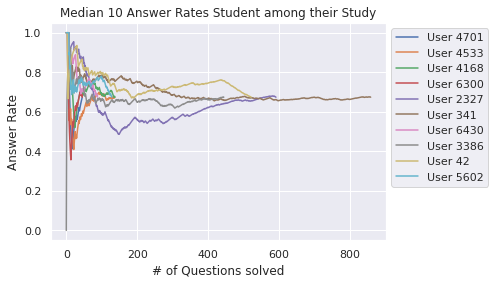

In [64]:
fig, ax = plt.subplots()

ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]

for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')


ax.legend(bbox_to_anchor=(1, 1))

- 정답률이라는 값이 (맞은 문항의 개수) / (푼 문항의 개수) 이다보니, 초반에는 값이 거의 1/0에 가깝다.
- 초반에 문제를 잘 푼 학생들은 항상 감소하는 추세를 보이고, 반대의 경우는 증가하는 추세를 보이게 된다.
- 전체를 보기보단, 현재부터 앞의 N개 문항에 대한 정답률을 보면 나아질 것 같다.

Window_size 적용

- Window size는 앞의 N문항에 대한 정답률만 계산한다는 의미입니다.

In [66]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

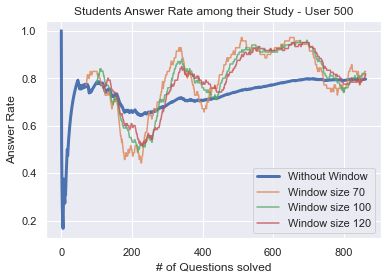

In [28]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

누적 정답률과, Window Size 적용한 정답률 비교

- 어떨 때는 어렵고 어떨 때는 쉬운 문제들이 나타나나 보다.

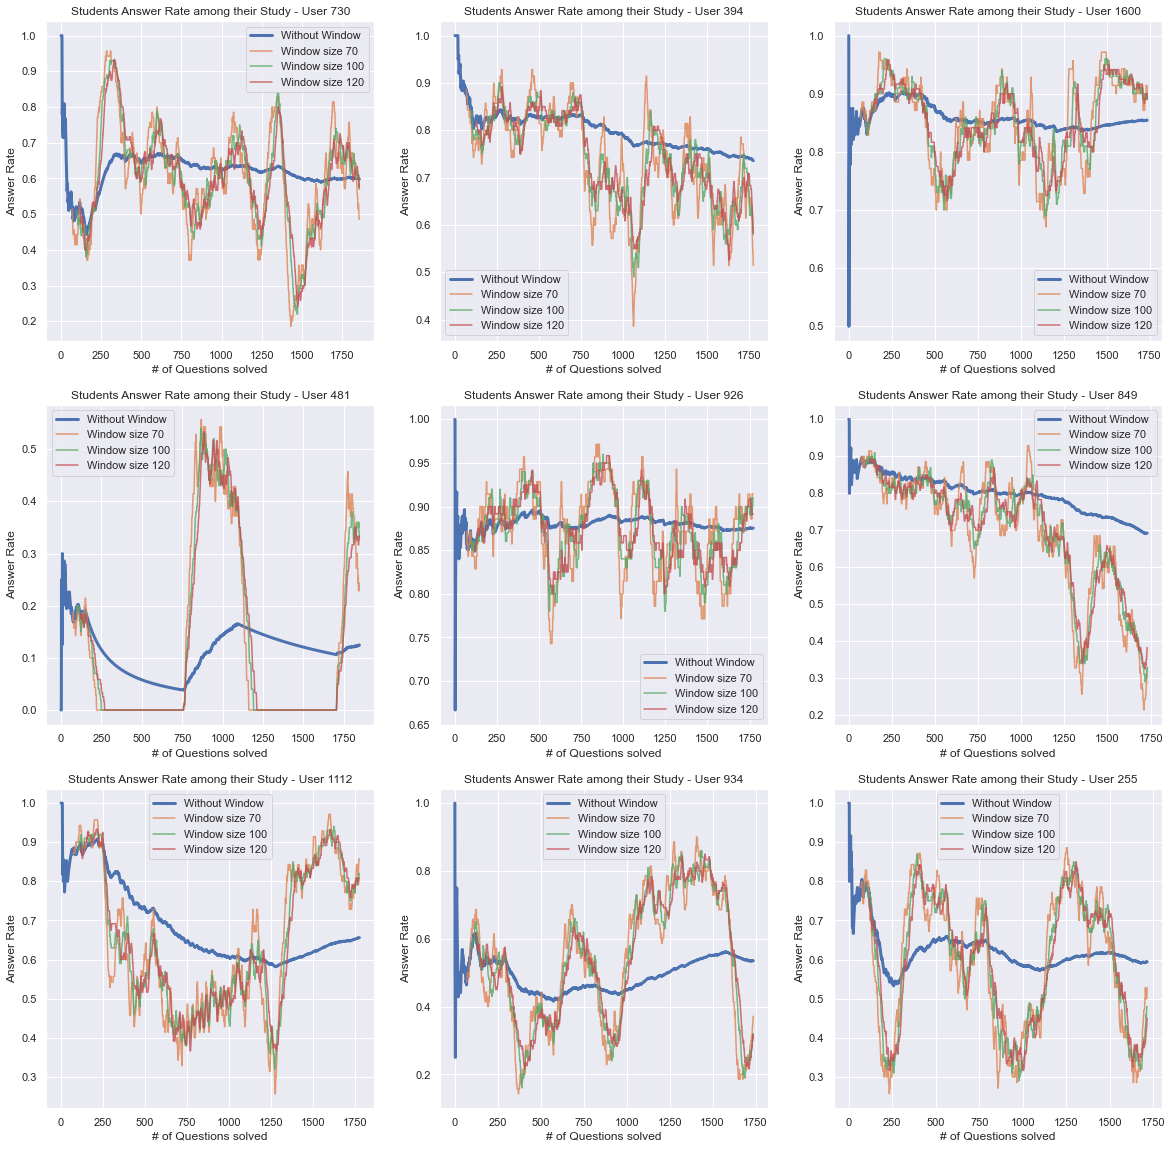

In [29]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')

for i, userID in enumerate(idx):    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

중앙값 부근인 10명의 학생들을 Window를 활용해 다시 그래프를 그린 것

- Feature를 추가해서 CV Score가 올라가고 LB Score가 올라가면 좋은 것
- 최근 몇 개의 문항에 대한 정답률을 활용하면, 다음 문항을 맞출 수 있을지 어느 정도의 통찰을 가질 수 있을 것 같습니다.

CV or Public : Over Fitting <br>
CV and Public : 중요

### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [30]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

(-10.0, 650.0)

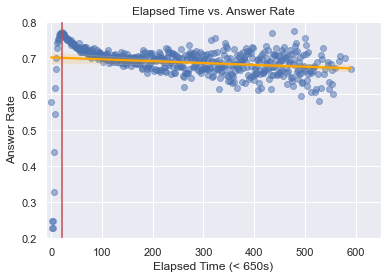

In [31]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

빨리 푼 문항은 정답률이 낮다

데이터에는 문제를 풀기 시작한 시간 밖에 없다.

시간 간격은 2번과 1번의 차이시간

상관관계와 인과관계는 다르다.

- 정답률이 높아지기 위해서 22초에 풀겠다.
    - 이상하다.
- 22초에 정답률이 높더라

# 2. Daily Mission

### (a)
사실 위에서 그린 문항수-정답률 그래프는 큰 insight를 주지 못하는 것 같습니다. 같은 문항을 푼 학생들의 정답률은 당연히 상이하겠지만, 이 평균을 보는 것이 더 의미가 있을 것 같은데 아래처럼 보면 너무 점이 많아서 insight를 얻기 힘드네요.
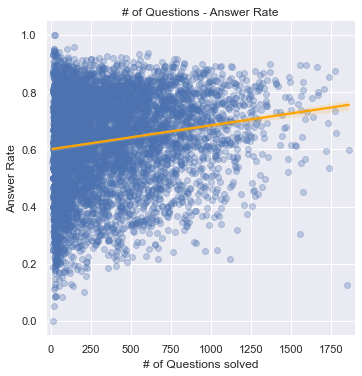

그러면 이번엔 같은 문항수를 푼 학생들이 있다면, 그 학생들의 평균을 찍어서 그래프를 그려봅시다. 가령 9문항을 푼 학생이 10명이라면, 그 학생들의 평균이 찍히도록 말이죠! 아래와 같은 형태이면 좋을 것 같습니다.
- **x-axis**: 사용자가 푼 문항의 수
- **y-axis**: 정답률
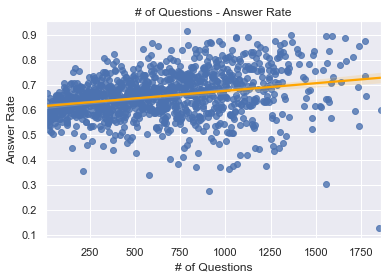

### (b)

그런데 위 그래프도... 사실 점이 너무 많습니다. 이것보다 더 줄이려면 단순히 같은 문항수를 푼 학생들끼리 평균을 집계하는 것이 아니라, 어느 정도 비슷한 문항을 푼 학생들을 전부 집계하면 좋을 것 같네요. 예를 들면 9 ~ 14문항을 푼 학생들을 묶어서 평균을 내는 것처럼요.   
`bins` 값을 주었을 때 bins 만큼 그래프에 점이 찍히도록, 예를 들어 bins=500이었다면 아래와 같이 500개의 bin을 만들어서 그래프가 그려지도록 해주세요 :)    

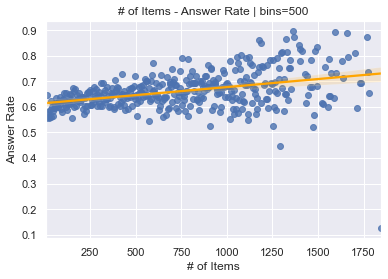